# Customer Subscription Renewal Rates

You are a Data Scientist at a SaaS company analyzing customer subscription renewal rates across 15 different marketing channels. The goal is to get stable, reliable estimates of the true renewal rate ($\theta_j$) for each channel $j$, especially for channels with very few customers (low sample size).A Frequentist approach might lead to extreme estimates for low-sample channels (e.g., $100\%$ or $0\%$ renewal), which is misleading. Bayesian hierarchical modeling allows partial pooling of information, leading to more robust estimates.

In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("data.csv").drop(columns="Observed Rate")

df

,Channel,Total Customers,Renewals
0,1,50,40
1,2,100,75
2,3,500,325
3,4,200,140
4,5,10,8
5,6,75,45
6,7,150,115
7,8,30,15
8,9,400,290
9,10,250,165


Model specification:
$$
\begin{aligned}
k_j | \theta_j & \sim \text{Binomial}(N_j, theta_j) \\
\theta_j | \alpha, \beta & \sim \text{Beta}(\alpha, \beta) \\ 
\alpha, \beta & \sim \text{Uniform}(1, 10)
\end{aligned}
$$

In [3]:
with pm.Model(coords={"channels": [f"Channel {i}" for i in range(1, 16)]}) as model:
    alpha = pm.Gamma("alpha", 1, 1)
    beta = pm.Gamma("beta", 1, 1)

    renewal_rate = pm.Deterministic("mu", alpha / (alpha + beta))
    variability = pm.Deterministic("kappa", alpha + beta)

    theta = pm.Beta("theta", alpha=alpha, beta=beta, dims="channels")

    renewals = pm.Binomial(
        "renewals",
        n=df["Total Customers"],
        p=theta,
        observed=df["Renewals"],
        dims="channels",
    )

    trace = pm.sample(4000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 4 seconds.


In [4]:
az.summary(trace, var_names=["mu", "kappa", "theta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.679,0.048,0.590,0.768,0.000,0.000,16911.0,13432.0,1.0
kappa,6.578,2.244,2.697,10.744,0.022,0.021,10340.0,10972.0,1.0
theta[Channel 1],0.786,0.055,0.682,0.884,0.000,0.000,28888.0,12098.0,1.0
theta[Channel 2],0.746,0.043,0.665,0.825,0.000,0.000,24890.0,11178.0,1.0
theta[Channel 3],0.651,0.021,0.610,0.689,0.000,0.000,22734.0,12314.0,1.0
theta[Channel 4],0.700,0.032,0.640,0.760,0.000,0.000,27229.0,12067.0,1.0
theta[Channel 5],0.755,0.105,0.562,0.941,0.001,0.001,21084.0,10373.0,1.0
theta[Channel 6],0.607,0.054,0.504,0.704,0.000,0.000,28192.0,10478.0,1.0
theta[Channel 7],0.763,0.034,0.700,0.827,0.000,0.000,24849.0,11999.0,1.0
theta[Channel 8],0.533,0.083,0.374,0.683,0.001,0.001,25603.0,11984.0,1.0


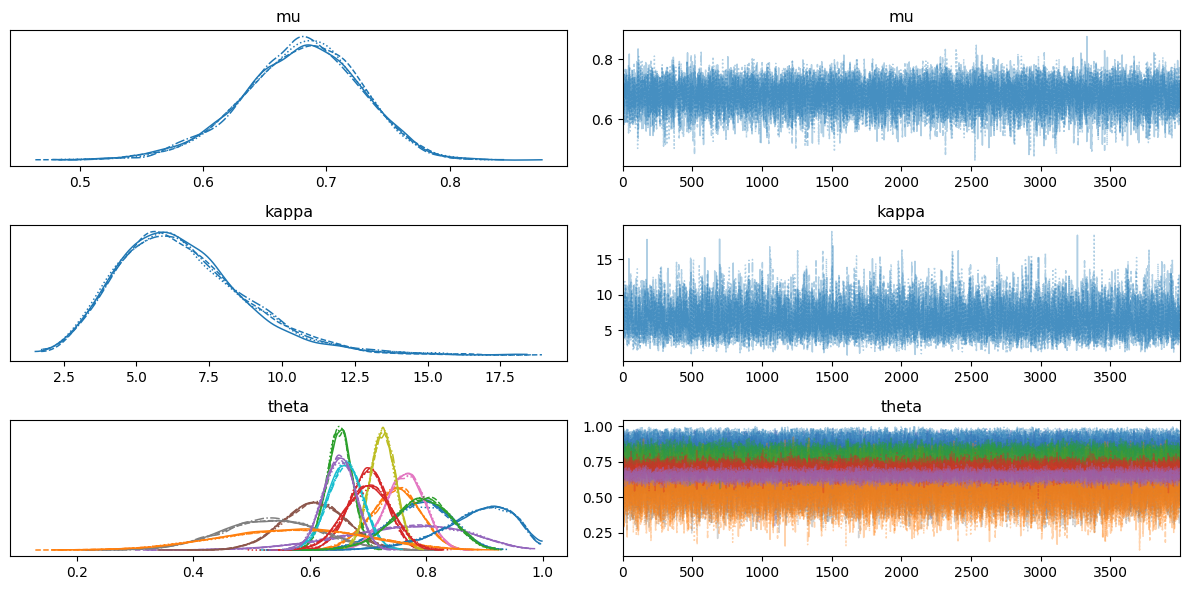

In [5]:
az.plot_trace(trace, var_names=["mu", "kappa", "theta"])

plt.tight_layout()
plt.show()

In [6]:
posterior_samples = trace.posterior["theta"].values.reshape(-1, df["Channel"].nunique())
winning_channel_idx = np.argmax(posterior_samples, axis=1)
winner_counts = np.bincount(winning_channel_idx, minlength=df["Channel"].nunique())
winner_counts = winner_counts / winner_counts.sum()

results = df.copy().assign(
    Channel=lambda df: df["Channel"].apply(lambda name: f"Channel {name}"),
    posterior_mean=az.summary(trace, var_names=["theta"])["mean"].values,
    prob_of_being_best=winner_counts,
)

results.sort_values(["prob_of_being_best", "posterior_mean"], ascending=False)

,Channel,Total Customers,Renewals,posterior_mean,prob_of_being_best
10,Channel 11,20,19,0.884,0.753437
4,Channel 5,10,8,0.755,0.102938
0,Channel 1,50,40,0.786,0.063812
12,Channel 13,60,48,0.789,0.061312
6,Channel 7,150,115,0.763,0.008812
1,Channel 2,100,75,0.746,0.007188
11,Channel 12,10,5,0.570,0.002000
8,Channel 9,400,290,0.724,0.000250
13,Channel 14,120,84,0.699,0.000188
3,Channel 4,200,140,0.700,0.000063


To choose the top 3 best channels (the ones with the highest rates of renewals, given the data), we calculate the proportion of times each channel has been the best (aka, ranked 1, or had the highest $\theta_j$). We should choose Channels 11, 5 and 1.